<span style="color:blue">
    
# **_Ultimate 25k+ Football Matches Database_**</span>

<div class="alert alert-warning">
<font color= black>
    
## **_Part I: Introduction_** </font></div>

<span style="color:blue">

### **_1. Introduction_** </span>

**Guiding questions:** My overall goal for this project was to explore how machine learning might provide a competitive advantage in sports betting. 

* Q1. Which leagues are in which countries?
* Q2. Which leagues score the most/fewest goals?
* Q3. Who are the top scorers in each team and league?
* Q4. Is there such a thing as home advantage?
* Q5. Can we predict how many goals each team will score in each match?
* Q6. Can we predict which team will win the match?

**Data source:**
* The project dataset was obtained from Kaggle [Ultimate 25k+ Matches Football Database -European](https://www.kaggle.com/datasets/prajitdatta/ultimate-25k-matches-football-database-european), and the documentation describes three data sources available at the following links: (1) [scores, lineup, team formation and events](https://www.enetscores.com/football)   (2) [betting odds](http://www.football-data.co.uk/) and (3) [players and teams attributes from EA Sports FIFA](http://sofifa.com/). The dataset consists of 7 key tables with information on 11 leagues/countries, 299 teams, and 25979 matches taking place between 2008 and 2016.

**Overall assumptions**

* I'm not a subject matter expert and I was not able to find a data dictionary for this dataset, so this analysis assumes I made correct assumptions of dataset variables (I consulted a LLM).


In [1]:
# Import libraries

# Systems and database libraries
import os
import sqlite3
import warnings

import matplotlib.pyplot as plt
import numpy as np

# Data manipulation/analysis libraries
import pandas as pd
import plotly.express as px

# Visualization
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Formatting
from IPython.display import display, HTML, IFrame
from autofeat import AutoFeatClassifier
from mlxtend.feature_selection import SequentialFeatureSelector

# Stats
from scipy.stats import chi2_contingency
from sklearn import metrics
from sklearn.linear_model import (
    LogisticRegression,
)
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Import functions
from utils.functions import (
    parse_xmlcol_to_df,
    calculate_hwin_sum,
    calculate_hloss_sum,
    calculate_win_rate,
    round_to_decimal_places,
    add_log_transformations,
    fit_linear_regression,
    plot_residuals,
    calculate_goal_diff,
    plot_pairplot,
    looker_link,
)

print("End of imports")

End of functions module
End of imports


In [2]:
current_dir = os.getcwd()
print(current_dir)

%reload_ext jupyter_black
warnings.filterwarnings("ignore")

class color:
    bold = "\033[1m"
    end = "\033[0m"

C:\Users\yashi\Dropbox\00 Turing Projects\_Turing repo clone\repo_ext\yashin_ext\football project


<div class="alert alert-warning">
<font color= blue>
    
## **_Part II: Initial data cleaning and EDA_**  </font></div>

In [3]:
conn = sqlite3.connect(".\database.sqlite")  # connection object
cur = conn.cursor()  # cursor obj for interacting with db
football_dict = {}

schema = conn.execute("SELECT name FROM sqlite_schema WHERE type='table'")

In [4]:
for tbl in schema:
    print(str(tbl[0]))
    query = "SELECT * from " + str(tbl[0]) + ";"  # str() takes out quotation marks
    football_dict[tbl[0]] = pd.read_sql_query(query, conn)

sqlite_sequence
Player_Attributes
Player
Match
League
Country
Team
Team_Attributes


In [5]:
# fmt: off
table_names = ["sqlseq", "player_att","player", "match", "league", "country", "team", "team_att"]

for new_df_name, table_name in zip(table_names, football_dict):
    locals()[new_df_name] = football_dict[table_name]

<font color= blue>

### **_1. Database structure and contents_** </font>

* Please refer to _football_univariateEDA.ipynb_ for more details on missing data.

In [6]:
pdf_path = "Football ER diagramme.pdf"

pdf_display = IFrame(src=pdf_path, width="100%", height="600px")

display(pdf_display)

<span style="color:blue">

### **_2. Univariate analysis_**</span>

* Please refer to _football_univariateEDA.ipynb_ for EDA on the distribution of individual variables

<span style="color:blue">
    
#### **_Insights from dataset parameters and cleaning_** </span>

<div class="alert alert-warning">
<font color= black>
    
## **_Part III: Exploratory data analysis:_** 

##### **_Four questions to better understand the football data_** </font></div>


<span style="color:blue">

### **_Q1 Which leagues are in which countries?_**</span>

In [7]:
query = """
SELECT l.name league, c.name country
    FROM League l
        JOIN Country c ON l.country_id = c.id
"""

ctry_league = pd.read_sql_query(query, conn)
ctry_league

league      country
0     Belgium Jupiler League      Belgium
1     England Premier League      England
2             France Ligue 1       France
3      Germany 1. Bundesliga      Germany
4              Italy Serie A        Italy
5     Netherlands Eredivisie  Netherlands
6         Poland Ekstraklasa       Poland
7   Portugal Liga ZON Sagres     Portugal
8    Scotland Premier League     Scotland
9            Spain LIGA BBVA        Spain
10  Switzerland Super League  Switzerland

<span style="color:blue">
    
#### **_Q1. Findings_**</span>

* There are 11 leagues, one in each of the following EU countries: Belgium, England, France, Germany, Italy, Netherlands, Poland, Portugal, Spain, Switzerland.

<span style="color:blue">
    
### **_Q2. Which leagues score the most/fewest goals?_** </span>

Since the leagues have different numbers of teams, we addressed this question by identifying the leagues that score the most/fewest goals per match rather than 
most/fewest goals


In [8]:
# Since the leagues have different numbers of teams, we addressed this question by
# identifying the leagues that score the most/fewest goals per match rather than
# most/fewest goals

query = """
SELECT m.home_team_goal, m.away_team_goal, l.name league, m.id
    FROM Match m
        JOIN League l ON m.league_id = l.id
"""

match_league = pd.read_sql_query(query, conn)
match_league.head()

home_team_goal  away_team_goal                  league  id
0               1               1  Belgium Jupiler League   1
1               0               0  Belgium Jupiler League   2
2               0               3  Belgium Jupiler League   3
3               5               0  Belgium Jupiler League   4
4               1               3  Belgium Jupiler League   5

In [9]:
# fmt: off
# Calculate total goals per league
home_goals = match_league.groupby("league")["home_team_goal"].sum().sort_values(axis=0)
away_goals = match_league.groupby("league")["away_team_goal"].sum().sort_values(axis=0)

# Count # of matches per league
total_matches = match_league.groupby("league")["id"].count().sort_values(axis=0).to_frame()
total_matches.rename(columns={"id": "total_matches"}, inplace=True)

# Merge by league 
goals_by_league = pd.merge(home_goals, away_goals, left_index=True, right_index=True)
goals_by_league["total_goals"] = goals_by_league["home_team_goal"] + goals_by_league["away_team_goal"]

# Merge total matches and calculate goals per match
goals_by_league = goals_by_league.merge(total_matches, left_index=True, right_index=True).sort_values(by="total_goals")
goals_by_league["goals_per_match"] = goals_by_league["total_goals"] / goals_by_league["total_matches"]

# Sort and reset index
goals_by_league.sort_values(by="goals_per_match", ascending=False, inplace=True)
goals_by_league.reset_index(inplace=True)

# Find leagues with min and max goals per match
league_min_goals = goals_by_league.loc[goals_by_league["goals_per_match"].idxmin(), "league"]
league_max_goals = goals_by_league.loc[goals_by_league["goals_per_match"].idxmax(), "league"]

display(goals_by_league)
print("")
print(f'League with fewest goals: {league_min_goals}')
print(f'League with most goals: {league_max_goals}')
print("")

league  home_team_goal  away_team_goal  total_goals  \
0     Netherlands Eredivisie            4357            3185         7542   
1   Switzerland Super League            2365            1801         4166   
2      Germany 1. Bundesliga            3982            3121         7103   
3     Belgium Jupiler League            2781            2060         4841   
4            Spain LIGA BBVA            4959            3453         8412   
5     England Premier League            4715            3525         8240   
6    Scotland Premier League            2607            2197         4804   
7              Italy Serie A            4528            3367         7895   
8   Portugal Liga ZON Sagres            2890            2311         5201   
9             France Ligue 1            4265            3162         7427   
10        Poland Ekstraklasa            2678            1978         4656   

    total_matches  goals_per_match  
0            2448         3.080882  
1            1422         2.929677  
2            2448         2.901552  
3            1728         2.801505  
4            3040         2.767105  
5            3040         2.710526  
6            1824         2.633772  
7            3017         2.616838  
8            2052         2.534600  
9            3040         2.443092  
10           1920         2.425000


League with fewest goals: Poland Ekstraklasa
League with most goals: Netherlands Eredivisie



<span style= "color:blue">

#### **_Q2 Findings_**</span>

* Leagues scoring most goals: Spain LIGA BBVA
* Leagues scoring fewest goals: Switzerland Super League

Observation:
* There appears to be a notable difference among leagues with respect to number of goals scored; perhaps the feature league should be considered in modelling goals and/or wins

<span style="color:blue">
    
### **_Q3. Who are the top scorers in each team and league?_**

#### **_Q3.1 Top scoring team in each league_**</span>

In [10]:
query = """
SELECT MAX(m.home_team_goal) Highest_scorer, l.name, t.team_long_name
FROM Match m
JOIN Team t on home_team_api_id = t.team_api_id
JOIN League l on m.league_id = l.id
GROUP BY l.name
"""
top_league_scorer = pd.read_sql_query(query, conn)

query = """
SELECT MIN(m.home_team_goal) Lowest_scorer, l.name, t.team_long_name
FROM Match m
JOIN Team t on home_team_api_id = t.team_api_id
JOIN League l on m.league_id = l.id
GROUP BY l.name
"""
lowest_league_scorer = pd.read_sql_query(query, conn)

<span style="color:blue">

##### **_Q3.1 Findings_**</span>

In [11]:
# fmt: off
print(color.bold + f"\n\nThe top scorers in each league are:\n" + color.end)
display(top_league_scorer)



The top scorers in each league are:



Highest_scorer                      name           team_long_name
0                7    Belgium Jupiler League           RSC Anderlecht
1                9    England Premier League        Tottenham Hotspur
2                6            France Ligue 1               LOSC Lille
3                9     Germany 1. Bundesliga         FC Bayern Munich
4                7             Italy Serie A                 Juventus
5               10    Netherlands Eredivisie                      PSV
6                6        Poland Ekstraklasa            GKS Bełchatów
7                8  Portugal Liga ZON Sagres               SL Benfica
8                9   Scotland Premier League                   Celtic
9               10           Spain LIGA BBVA           Real Madrid CF
10               7  Switzerland Super League  Grasshopper Club Zürich

<span style="color:blue">

#### **_Q3.2 Top scoring player in each team_**</span>

In [12]:
match_goalxml = match[["id", "goal"]]
match_goalxml = match_goalxml.rename(columns={"id": "match_id"})
df = match_goalxml
goalxml_parsed = parse_xmlcol_to_df(match_goalxml, "goal")

goalxml_df = pd.DataFrame(goalxml_parsed)
display(goalxml_df.head()), goalxml_df.shape

match_id  goal value comment stats goals shoton event_incident_typefk  \
0      1729  None  None       n  None     1      1                   406   
1      1729  None  None       n  None     1      1                   393   
2      1729  None  None       n  None     1      1                   393   
3      1729  None  None       n  None     1      1                   407   
4      1729  None  None       n  None     1      1                   393   

  elapsed player2  ...      id    n  type goal_type penalties elapsed_plus  \
0      22   38807  ...  378998  295  goal         n         1            2   
1      24   24154  ...  379019  298  goal         n         1            5   
2       4   39297  ...  375546  231  goal         n         1            3   
3      83   30889  ...  378041  344  goal         n         1            2   
4       4   36394  ...  376060  244  goal         n         1            3   

  owngoals del coordinates shotoff  
0        1   1        None       1  
1        1   1        None       1  
2        1   1        None    None  
3        1   1        None    None  
4        1   1        None    None  

[5 rows x 24 columns]

(None, (639821, 24))

In [13]:
# fmt: off
# Prep data for merge: convert column IDs to correct data type
goalxml_df["team"] = pd.to_numeric(goalxml_df["team"], errors="coerce").fillna(0).round(0).astype(int)
goalxml_df["player1"] = (pd.to_numeric(goalxml_df["player1"], errors="coerce").fillna(0).round(0).astype(int))
goalxml_lean = goalxml_df[["id", "goals", "team", "player1"]]

# Merge to get names of teams and players 
goal_teams = goalxml_lean.merge(team, how="left", left_on="team", right_on="team_api_id")
goals = goal_teams.merge(player, how="left", left_on="player1", right_on="player_api_id")

# Merged df goals
display(goals.head()), goals.shape # 62136 rows and 16 columns

id_x goals   team  player1    id_y  team_api_id  team_fifa_api_id  \
0  378998     1  10261    37799  3458.0      10261.0              13.0   
1  379019     1  10260    24148  3457.0      10260.0              11.0   
2  375546     1   9825    26181  3459.0       9825.0               1.0   
3  378041     1   8650    30853  3462.0       8650.0               9.0   
4  376060     1   8654    23139  3463.0       8654.0              19.0   

      team_long_name team_short_name      id  player_api_id      player_name  \
0   Newcastle United             NEW  8079.0        37799.0  Obafemi Martins   
1  Manchester United             MUN  2291.0        24148.0  Darren Fletcher   
2            Arsenal             ARS  9428.0        26181.0      Samir Nasri   
3          Liverpool             LIV  3335.0        30853.0  Fernando Torres   
4    West Ham United             WHU  2485.0        23139.0      Dean Ashton   

   player_fifa_api_id             birthday  height  weight  
0            137494.0  1984-10-28 00:00:00  170.18   161.0  
1            138782.0  1984-02-01 00:00:00  182.88   163.0  
2            165239.0  1987-06-26 00:00:00  175.26   165.0  
3             49369.0  1984-03-20 00:00:00  185.42   172.0  
4               636.0  1983-11-24 00:00:00  185.42   172.0

(None, (639821, 16))

In [14]:
# fmt: off
# Drop if team or player ID columns from any of the forming tables are null
goals = goals.dropna(subset=["team_api_id", "team", "player1", "player_api_id"])
display(goals.shape)  # 39655 rows, 35 cols

# How many teams are represented? Verify that team and team_long_name have 1-to-1 correspondence
display(goals.team.nunique())  # 199 teams--data not available for all teams (N=299)
display(goals.team_long_name.nunique())  # 199 teams 

(39665, 16)

199

199

* Identify highest scoring player for each team

In [15]:
# fmt: off
goals["goals"] = pd.to_numeric(goals["goals"])

<span style= "color:blue">

##### **_Q3.2 Findings_**</span>

The table below the next code cell provides a summary of the highest scoring player for each team, for which data were available

In [16]:
# fmt: off
# Group by team and player to calculate sum of goals for each player in each team
# Note: A player may play in more than one team
sum_goals_players = (goals.groupby(["team_long_name", "player_name"])["goals"].sum().reset_index())

# Identify player with the highest total goals for each team 
max_goals_per_team = sum_goals_players.loc[sum_goals_players.groupby("team_long_name")["goals"].idxmax()]
max_goals_per_team.sort_values("goals", ascending=False, inplace=True)

top_10_scorers = max_goals_per_team.head(10)
print(color.bold + f'\n\nFigure 1. Top 10 highest scorers per team:\n' + color.end)
display(top_10_scorers)
top_10_scorers.to_csv("top_10_scorers.csv")

HTML(
    looker_link(
        "https://lookerstudio.google.com/reporting/049799d6-908c-429a-b157-01fd5a2455c5/page/p_fujvza42bd/edit",
        "Click here to see this chart rendered in Looker Studio (Figure 1).",
    )
)



Figure 1. Top 10 highest scorers per team:



team_long_name          player_name  goals
13276    Manchester United         Wayne Rooney   24.0
6936          FC Barcelona         Lionel Messi   19.0
12569            Liverpool       Steven Gerrard   18.0
5239               Chelsea       Nicolas Anelka   16.0
3034   Bayer 04 Leverkusen     Stefan Kiessling   16.0
15067   Olympique Lyonnais   Zlatan Ibrahimovic   15.0
7281      FC Bayern Munich  Klaas Jan Huntelaar   14.0
18659                 Roma       Edinson Cavani   14.0
17787       Real Madrid CF         Lionel Messi   14.0
7916         FC Schalke 04      Alexander Meier   12.0

<span style="color:blue">
    
### **_Q4. Is there such a thing as home advantage?_**</span>
To answer this question as accurately as possible in an ideal scenario, one would want to control for such confounders as:
- **team composition:** a team by the same name is actually composed of different players for different games and the composition changes over one game
- **relative team strength/skill:** both home and opposing teams for different matches differ in their strengths, skills and composition
- **away match location:** assuming that a potential home advantage is largely mediated by fan support, fan access to nearby away matches could be similar to that of home matches

In this context, we will address this question at a high level and simply compare average win rates for teams at home and away matches. A key assumption for this approach is that teams are as likely to play at home as away, which is a feature of these European leagues. 

**H<sub>0</sub>**: There is no difference between average team win rates for home matches vs away matches

**H<sub>A</sub>**: Average win rates for teams in home matches are significantly different than average win rates for teams in away matches.

* Calculate win rate = (number of matches won)/(total number of matches)

In [17]:
# fmt: off
# Step X:

match["hteam_win"] = 0
match["ateam_win"] = 0

match["hteam_win"].loc[match["home_team_goal"] > match["away_team_goal"]] = 1
match["ateam_win"].loc[match["away_team_goal"] > match["home_team_goal"]] = 1

hteam_wins = np.array(match["hteam_win"])
hwin_rate = np.mean(hteam_wins)  # 45.9%

ateam_wins = np.array(match["ateam_win"])
awin_rate = np.mean(ateam_wins)  # 28.7%

print(f"\n\nHome team win rate: {round(hwin_rate*100, 1)} \nAway team win rate: {round(awin_rate*100, 1)}")



Home team win rate: 45.9 
Away team win rate: 28.7


In [18]:
# fmt: off
# Contingency table
contingency_table = [[sum(hteam_wins), len(hteam_wins) - sum(hteam_wins)],
    [sum(ateam_wins), len(ateam_wins) - sum(ateam_wins)]]

# Chi2
stat, p, dof, expected = chi2_contingency(contingency_table)
print("Chi-squared statistic:", stat)
print("P-value:", p)

Chi-squared statistic: 1629.5475115684167
P-value: 0.0


<span style="color:blue">
    
#### **_Q4. Finding: Home advantage_**</span>

We reject the **H<sub>0</sub>** of no difference between average team win rates for home matches vs away matches. 

**H<sub>A</sub>**: Average win rates for teams in home matches are significantly different than average win rates for teams in away matches.

<span style="color:blue">
    
## **_Part IV: Prediction_** </span>

<span style="color:blue">
    
### **_Q6 Can we predict which team will win the match?_**</span>

* We will interpret this question as the probability of the home team winning a match
  - According to the literature, draws are very challenging to predict, so we will sidestep this issue in this first football modelling attempt. 


* Plan:
  (1) Select columns of interest in each table to reduce merge/join computing time
  (2) Join attempt using SQL caused freezing with no results after 3 hours and required frequent restarting computer for each additional attempt

In [19]:
# fmt: off
# Merge match with league & teams to provide column names for league, home and away teams

query = """
SELECT m.id, m.season, m.stage, m.date, m.home_team_api_id, m.away_team_api_id, m.home_team_goal hgoal, m.away_team_goal agoal, 
m.home_player_1, m.home_player_2, m.home_player_3, m.home_player_4, m.home_player_5, m.home_player_6, m.home_player_7, m.home_player_8, m.home_player_9, m.home_player_10, m.home_player_11, 
m.away_player_1, m.away_player_2, m.away_player_3, m.away_player_4, m.away_player_5, m.away_player_6, m.away_player_7, m.away_player_8, m.away_player_9, m.away_player_10, m.away_player_11,
t1.team_long_name hteam, t2.team_long_name ateam, c.name country
FROM Match m
JOIN Country c on c.id = m.country_id
JOIN Team t1 on home_team_api_id = t1.team_api_id
JOIN Team t2 on away_team_api_id = t2.team_api_id
"""

match_names = pd.read_sql_query(query, conn)
match_names.shape  # 25979 rows and 33 columns

(25979, 33)

<span style="color:blue">
    
#### **_Q6.1 Create variables for modelling (feature extraction)_** </span>

In [20]:
# Create variables to include in model         ------------ home_win, away_win ----------------

# Create outcome variable: home_win
match_names["home_win"] = np.zeros(len(match_names))
match_names.loc[match_names.hgoal > match_names.agoal, "home_win"] = 1

# Create outcome variable: away_win
match_names["away_win"] = np.zeros(len(match_names))
match_names.loc[match_names.hgoal < match_names.agoal, "away_win"] = 1

# VerifY
match_names[["hgoal", "agoal", "home_win", "away_win"]].sample(10)

hgoal  agoal  home_win  away_win
17920      2      1       1.0       0.0
15688      2      1       1.0       0.0
24544      2      2       0.0       0.0
7013       1      1       0.0       0.0
325        2      0       1.0       0.0
15211      2      2       0.0       0.0
15133      1      1       0.0       0.0
15015      1      1       0.0       0.0
14238      1      2       0.0       1.0
856        1      1       0.0       0.0

In [21]:
# fmt: off              ------------ Overall goal: team_rating_diff ---------------

# Prep data for merging with player_att.overall_rating

# Identify list of player column names
player_cols = match_names.filter(like="player", axis=1).columns.tolist()

# Drop rows with null merge keys in match_names
match_names = match_names.dropna(subset=player_cols)
match_names.shape  # 21374 rows * 39 cols

# Match id--is it unique?
len(match_names.id.unique())  # yes, id is unique

21374

In [22]:
# fmt: off
# Convert keys to same data type for join
match_names.date = match_names.date.astype("datetime64[ns]")
match_names[player_cols] = match_names[player_cols].astype("int64")

player_att["date"] = pd.to_datetime(player_att["date"])
player_att.player_api_id = player_att.player_api_id.astype("int64")

# Sort both the DataFrames
match_names = match_names.sort_values("date")  # Sort df by 'home_player_1' to start the merge
player_att = player_att.sort_values("date")

# Select the 3 columns needed to extract overall rating for each of the 22 players in from player_att 
player_or = player_att[["player_api_id", "date", "overall_rating"]] 

In [23]:
# fmt: off
# Create dataframe with overall rating for each player for each match
# Create an empty list to store the merged DataFrames
merged_dfs = []

# Identify list of player column names
player_cols = match_names.filter(like="player", axis=1).columns.tolist()

# Loop through player columns to merge overall ratings for each player into separate DataFrames,
# using the player's overall_rating determined at a date before the match date
for player_num, col in enumerate(player_cols, start=1):
    merged = pd.merge_asof(
        match_names,
        player_or.reset_index(),
        on="date",
        left_by=col,
        right_by="player_api_id",
        direction="backward",
        tolerance=pd.Timedelta(days=365),
    )
    # Rename the 'overall_rating' column to specific player's number
    merged.rename(
        columns={"overall_rating": f"overall_rating_{player_num}"}, inplace=True
    )

    # Store 'id' column along with the new 'overall_rating' column
    merged_dfs.append(merged[["id", f"overall_rating_{player_num}"]])

# Concatenate individual overall ratings into one df
or_by_match = pd.concat(merged_dfs, axis=1)
or_by_match.columns.values[0] = "match_id"  # rename 1st instance of id into match_id
or_by_match = or_by_match.drop("id", axis=1)  # drop all other instances of id

In [24]:
# fmt: off
# Merge match_names and or_by_match
match_full = match_names.merge(or_by_match, how="left", left_on="id", right_on="match_id")
match_full.shape, match_full.columns

((21374, 58),
 Index(['id', 'season', 'stage', 'date', 'home_team_api_id', 'away_team_api_id',
        'hgoal', 'agoal', 'home_player_1', 'home_player_2', 'home_player_3',
        'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7',
        'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
        'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
        'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
        'away_player_9', 'away_player_10', 'away_player_11', 'hteam', 'ateam',
        'country', 'home_win', 'away_win', 'match_id', 'overall_rating_1',
        'overall_rating_2', 'overall_rating_3', 'overall_rating_4',
        'overall_rating_5', 'overall_rating_6', 'overall_rating_7',
        'overall_rating_8', 'overall_rating_9', 'overall_rating_10',
        'overall_rating_11', 'overall_rating_12', 'overall_rating_13',
        'overall_rating_14', 'overall_rating_15', 'overall_rating_16',
        'overall_rati

In [25]:
# fmt: off              ------------ hteam_rating, ateam_rating ----------------
# Calculate overall rating for home and away teams for each match
match_full["hteam_rating"] = match_full.loc[
    :, "overall_rating_1":"overall_rating_11"
].sum(axis=1)
match_full["ateam_rating"] = match_full.loc[
    :, "overall_rating_12":"overall_rating_22"
].sum(axis=1)

# set index
match_full.set_index("match_id").head()

id     season  stage       date  home_team_api_id  \
match_id                                                        
4770      4770  2008/2009      1 2008-08-09              9827   
4774      4774  2008/2009      1 2008-08-09              9829   
4771      4771  2008/2009      1 2008-08-09              9746   
4775      4775  2008/2009      1 2008-08-09              8481   
4777      4777  2008/2009      1 2008-08-09              9874   

          away_team_api_id  hgoal  agoal  home_player_1  home_player_2  ...  \
match_id                                                                ...   
4770                  7819      2      1          30458          32571  ...   
4774                  9847      1      0         145039          41097  ...   
4771                  9831      1      0          41186          71607  ...   
4775                  8639      0      0          26233         111909  ...   
4777                  9855      1      2          26359         147351  ...   

          overall_rating_15  overall_rating_16  overall_rating_17  \
match_id                                                            
4770                   67.0               66.0               76.0   
4774                   77.0               78.0               75.0   
4771                   67.0               75.0               74.0   
4775                   56.0               77.0               76.0   
4777                   68.0               60.0               57.0   

          overall_rating_18  overall_rating_19  overall_rating_20  \
match_id                                                            
4770                   71.0               70.0               67.0   
4774                   75.0               85.0               82.0   
4771                   55.0               75.0               67.0   
4775                   73.0               76.0               79.0   
4777                   59.0               74.0               67.0   

          overall_rating_21  overall_rating_22  hteam_rating  ateam_rating  
match_id                                                                    
4770                   77.0                NaN         819.0         706.0  
4774                   61.0               70.0         678.0         807.0  
4771                   58.0               73.0         612.0         757.0  
4775                   77.0               69.0         768.0         797.0  
4777                   79.0                NaN         765.0         656.0  

[5 rows x 59 columns]

In [26]:
# Since wins are computed from the perspective of the home team, and lit search highlighted importance of opposing team,
# create variable that measures the magnitude in overall rating
match_full["team_rating_diff"] = match_full["hteam_rating"] - match_full["ateam_rating"]

In [27]:
# Drop individual player_id and overall_ratings
columns_to_drop = (
    [f"overall_rating_{i}" for i in range(1, 23)]
    + [f"home_player_{i}" for i in range(1, 12)]
    + [f"away_player_{i}" for i in range(1, 12)]
)

match_full.drop(columns=columns_to_drop, inplace=True)
match_full.shape

(21374, 17)

In [28]:
# Create team_rating_diff         --------- team_rating_diff, rating01 ------------
match_full["rating01"] = np.zeros(len(match_full))
match_full.loc[match_full["team_rating_diff"] > 0, "rating01"] = 1
match_full.columns

Index(['id', 'season', 'stage', 'date', 'home_team_api_id', 'away_team_api_id',
       'hgoal', 'agoal', 'hteam', 'ateam', 'country', 'home_win', 'away_win',
       'match_id', 'hteam_rating', 'ateam_rating', 'team_rating_diff',
       'rating01'],
      dtype='object')

In [29]:
#                                              ------------ shoton ----------------
# Create shoton (count) variable by parsing match.shoton xml field
# Reasoning: literature cites efficiency of shots (nbr of goals/nbr of shots) and shots on goal as among
# the most significant variables for prediction

# Extract match id and xml column match.shoton
match_shotonxml = match[["id", "shoton"]]
match_shotonxml = match_shotonxml.rename(columns={"id": "match_id"})

# Parse using previously created function (used to parse goal xml column)
shotonxml_parsed = parse_xmlcol_to_df(match_shotonxml, "shoton")

# Convert the dictionary of tag content into a DataFrame
shoton_full = pd.DataFrame(shotonxml_parsed)
display(shoton_full.head(), shoton_full.shape)

match_id shoton value stats blocked event_incident_typefk elapsed  \
0      1729   None  None  None       1                    61       3   
1      1729      1  None  None       1                   154       7   
2      1729      1  None  None       1                   153      14   
3      1729      1  None  None       1                   153      14   
4      1729      1  None  None       1                   137      17   

        subtype player1 sortorder   team    n    type      id elapsed_plus  \
0  blocked_shot   24154         0  10260  253  shoton  378828            2   
1        header   24157         2  10260  258  shoton  378866            3   
2          shot   30829         1  10260  274  shoton  378922            1   
3          shot   30373         2  10260  279  shoton  378923            3   
4      distance   30373         3  10260  272  shoton  378951            2   

  goal_type del coordinates card_type  
0        dg   1        None         y  
1         n   1        None      None  
2      None   1        None      None  
3      None   1        None      None  
4      None   1        None      None

(1264494, 19)

In [30]:
# fmt: off
# Group shotons by match and team

# Prep data for merging with match_full
shoton_full.loc[shoton_full["shoton"] == "\n\t\t", "shoton"] = np.nan  # clean incorrect entry

# Drop columns for which shoton is null
shoton_full.shoton.isna().sum()

# Number of matches represented
shoton_full["match_id"].nunique() # 14217 matches: too much missing data, unless there were actually games with no shot ons
shoton_full = shoton_full[~shoton_full["shoton"].isna()] # delete rows with NA for shoton variable
shoton_full["match_id"].nunique() # 479 matches even worse so decision to not use shoton data

479

In [31]:
# fmt: off                                    ------------ win_rate ----------------
# # Create variable win "rate" (ratio of [home team wins]/[home team wins + losses] for last 35 matches)

# Sort the DataFrame by date to ensure correct rolling sum calculation
match_full["date"] = pd.to_datetime(match_full["date"], format="%d-%m-%Y")
match_full = match_full.sort_values(by="date")

# Apply the functions to each group
# group_keys = False keeps grouping column "home_team_api_id" in the df post-groupby
match_full = match_full.groupby(
    "home_team_api_id", as_index=False, group_keys=False
).apply(calculate_hwin_sum)

match_full = match_full.groupby(
    "home_team_api_id", as_index=False, group_keys=False
).apply(calculate_hloss_sum)

# Reset index
match_full = match_full.reset_index(drop=True)

# Create win_rate variable, disregarding draws
match_full["win_rate"] = match_full.apply(calculate_win_rate, axis=1)

match_full.to_csv("test.csv", index=False)

In [32]:
# fmt: off                                 ------------ hx_goal_diff --------------
# # Create variable hx_goal_diff (historical goal difference) for last 35 matches of data available
match_full["goal_diff"] = match_full["hgoal"] - match_full["agoal"]
# from utils.functions import calculate_goal_diff

# Sort the DataFrame by date to ensure correct rolling sum calculation
match_full["date"] = pd.to_datetime(match_full["date"], format="%d-%m-%Y")
match_full = match_full.sort_values(by="date")

# Apply the functions to each group
# group_keys = False keeps grouping column "home_team_api_id" in the df post-groupby
match_full = match_full.groupby(
    "home_team_api_id", as_index=False, group_keys=False
).apply(calculate_goal_diff)

match_full["hx_goal_diff"] = match_full["hx_goal_diff"].fillna(0)

# Reset index
match_full = match_full.reset_index(drop=True)

In [33]:
# fmt: off                                     ------------ country ----------------

# Convert categorical var to dummy
categorical_column = [
    "country"
]  # country has fewer characters than league and they have 1:1 correspondence
categorical_data = match_full[categorical_column]

# Instantiate the OneHotEncoder
one_hot_encoder = OneHotEncoder(
    drop="first", sparse=False
)  # Belgium is the reference group

# Transform the data into array, then df
one_hot_encoded_data = one_hot_encoder.fit_transform(categorical_data)

one_hot_encoded_df = pd.DataFrame(
    one_hot_encoded_data,
    columns=one_hot_encoder.get_feature_names_out(categorical_column),
)

# Replace the original categorical columns with the dummy version
match_final = pd.concat([match_full, one_hot_encoded_df], axis=1)

In [34]:
match_final.shape, match_final.columns, match_final.to_csv("match_final.csv")

((21374, 33),
 Index(['id', 'season', 'stage', 'date', 'home_team_api_id', 'away_team_api_id',
        'hgoal', 'agoal', 'hteam', 'ateam', 'country', 'home_win', 'away_win',
        'match_id', 'hteam_rating', 'ateam_rating', 'team_rating_diff',
        'rating01', 'hwin_sum', 'hloss_sum', 'win_rate', 'goal_diff',
        'hx_goal_diff', 'country_England', 'country_France', 'country_Germany',
        'country_Italy', 'country_Netherlands', 'country_Poland',
        'country_Portugal', 'country_Scotland', 'country_Spain',
        'country_Switzerland'],
       dtype='object'),
 None)

<span style="color:blue">
    
#### **_Summary of variables constructed:_** </span> 
Added:
- **home_win** and **away_win**: the former will be the outcome variable for prediction
- **hteam_rating**, **ateam_rating**, and **team_rating_diff**: average of 11 individual overall ratings for players in each team; the difference between home team rating and away team rating
- **win_rate**: proportion of wins out of [wins + losses] for each home team that took place over the last 35 matches prior to each match, disregarding draws
- **hx_goal_diff**: difference between home team and away team goals in the last 35 matches 
- dummy variables: **country_England, country_France, country_Germany, country_Italy, country_Netherlands, country_Poland, country_Portugal, country_Scotland, country_Spain, country_Switzerland**

Considered but decided against
- **shoton** - Data are quite incomplete and earlier analysis appeared to show that one match id was associated with 20 teams, whereas we expected it to be associated with two (ie. home and away). In the absence of a subject matter expert, there was too much uncertainty to move forward with this possibiliy.


<span style="color:blue">
    
#### **_Intermission: Visualisations using new variables:_** </span> 

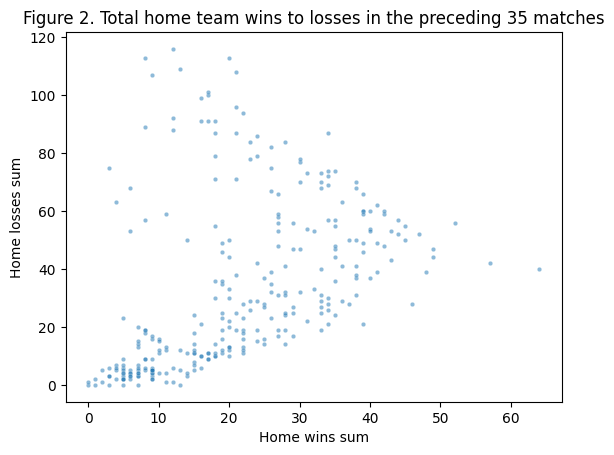

In [35]:
# fmt: off
# Viz #1: illustrate home team advantage
# Calculate total wins & losses for each home team
hteam_groups = match_full.groupby("home_team_api_id")

# Calculate sum of wins and losses for each group
hteam_win_loss = hteam_groups.agg({"home_win": "sum", "away_win": "sum",}).reset_index()
hteam_win_loss = hteam_win_loss.rename(columns = {"home_win":"hwin_sum", "away_win":"hloss_sum"})
hteam_win_loss.to_csv("hteam_wins_to_losses.csv")

# Now you can use hteam_win_loss_df with sns.scatterplot
sns.scatterplot(
    data=hteam_win_loss,
    y="hwin_sum",
    x="hloss_sum",
    s=10,  # Set marker size
    alpha=0.5,  # Set transparency
)

plt.xlabel("Home wins sum")
plt.ylabel("Home losses sum")
plt.title("Figure 2. Total home team wins to losses in the preceding 35 matches")

# Display Looker link
HTML(
    looker_link(
        "https://lookerstudio.google.com/reporting/049799d6-908c-429a-b157-01fd5a2455c5/page/HINjD",
        "Click here to see this chart rendered in Looker Studio (Figure 2).",
    )
)

In [36]:
# Viz #2: Identify teams with top win/loss ratio
# Calculate win/loss ratio
team_record = (
    match_full.groupby("home_team_api_id")[["home_win", "away_win"]]
    .agg("sum")
    .reset_index()
)
team_record.merge(
    team[["team_api_id", "team_long_name"]],
    left_on="home_team_api_id",
    right_on="team_api_id",
)
team_record["team_win_loss"] = np.where(
    team_record["away_win"] == 0,
    np.nan,
    team_record["home_win"] / (team_record["away_win"]),
)

team_record.sort_values("team_win_loss", ascending=False)
team_record_names = team_record.merge(
    team[["team_api_id", "team_long_name"]],
    left_on="home_team_api_id",
    right_on="team_api_id",
)

# Create df showing percentage of top 25 values for win/loss ratio
team_record_names25 = team_record_names.nlargest(25, "team_win_loss")
team_record_names25.reset_index(inplace=True)
team_record_names25.to_csv("team_record_names25.csv")

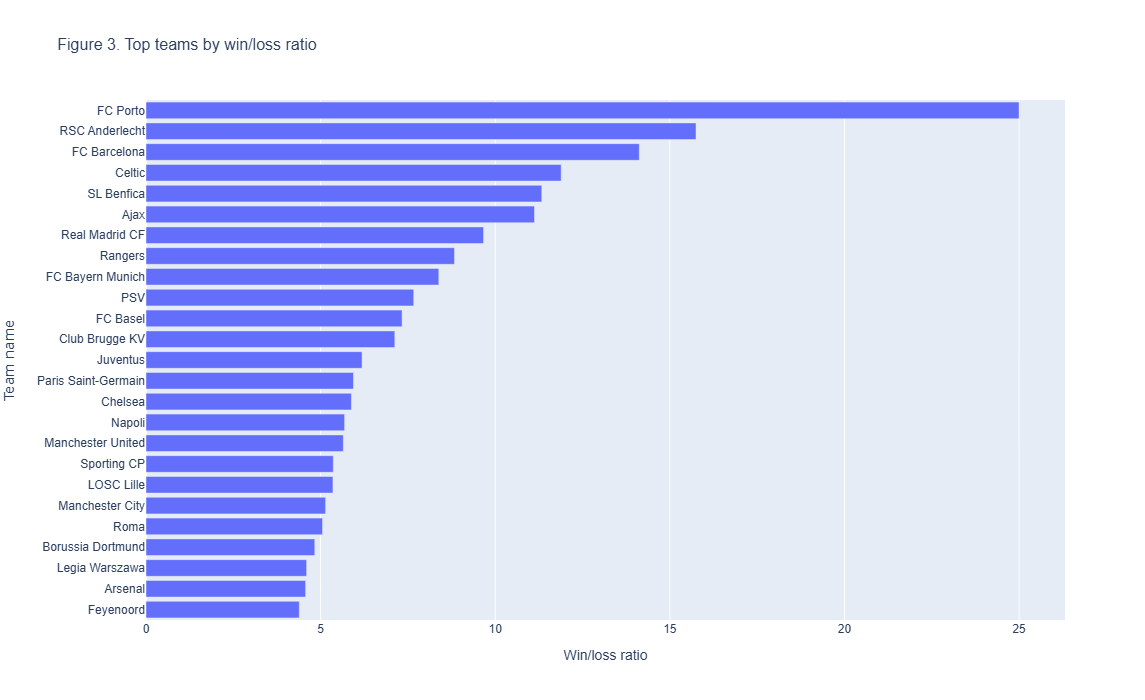

In [37]:
# Create a bar chart using Plotly
fig = px.bar(
    team_record_names25,
    x="team_win_loss",
    y="team_long_name",  # Check the exact name of the column here
    orientation="h",
    title="Team win/loss ratio",
)

# Update layout for better visualization
fig.update_layout(
    title="Figure 3. Top teams by win/loss ratio",
    xaxis_title="Win/loss ratio",  # Add the x-axis label
    yaxis_title="Team name",
    height=700,  # Adjust height
    width=600,  # Adjust width
    title_font=dict(size=16, family="Arial"),
    xaxis=dict(
        title_font=dict(size=14, family="Arial"),  # Customize the x-axis label font
        tickfont=dict(size=12, family="Arial"),  # Customize the x-axis tick font
    ),
    yaxis=dict(
        automargin=True, showticklabels=True, tickfont=dict(size=12, family="Arial")
    ),
)

# Reverse the order of the bars along the y-axis
fig.update_yaxes(categoryorder="total ascending")

# Add label to the left of the y-axis for clarity
fig.update_layout(
    yaxis=dict(
        automargin=True, showticklabels=True, tickfont=dict(size=12, family="Arial")
    )
)

# Show the figure
fig.show()

# Display Looker link
HTML(
    looker_link(
        "https://lookerstudio.google.com/reporting/049799d6-908c-429a-b157-01fd5a2455c5/page/p_ogo76422bd",
        "Click here to see this chart rendered in Looker Studio (Figure 3).",
    )
)

<span style="color:blue">
    
#### **_Q6.2 Split data into training and testing_** </span>

In [38]:
# Calculate total goals for last two seasons to use as a feature
# Recode season for easier manipulation
match_final.season.value_counts()
season_map = {
    "2008/2009": "1",
    "2009/2010": "2",
    "2010/2011": "3",
    "2011/2012": "4",
    "2012/2013": "5",
    "2013/2014": "6",
    "2014/2015": "7",
    "2015/2016": "8",
}
match_final["season1"] = match_final["season"].replace(season_map)

In [39]:
# fmt: off
# Split dataset into training and testing
match_final["season1"] = match_final["season1"].astype("int64")

# set index to id (which is same as match_id)
match_final.set_index("id", inplace = True)

# Define train and test datasets
train = match_final[(match_final["season1"] == 1) | (match_final["season1"] == 2) | (match_final["season1"] == 3) | (match_final["season1"] == 4) | (match_final["season1"] == 5) | (match_final["season1"] == 6)]
test = match_final[(match_final["season1"] == 7) | (match_final["season1"] == 8)]

match_final.shape, train.shape, test.shape

((21374, 33), (15375, 33), (5999, 33))

<span style="color:blue">
    
##### **_Q6.2.1 Check distribution of country after splitting dataset_**</span>

Because the datatset split was conducted by seasons rather than random selection, it is advisable to check that the distribution of the categorical variable is similar in the two datasets.

**H<sub>0</sub>**: The distribution of matches among countries (ie. leagues) is significantly different in the 
                    training vs full dataset. 

**H<sub>A</sub>**: The distribution of matches among countries (ie. leagues) is not significantly different between 
                    the training and the full dataset

In [40]:
# Verify that distribution of countries is not significantly different between training and full dataset
countries_train = train.country.value_counts()
countries_test = test.country.value_counts()
countries_merged = pd.merge(
    countries_train,
    countries_test,
    left_index=True,
    right_index=True,
    suffixes=("_train", "_test"),
)

data = pd.crosstab(countries_merged["count_train"], countries_merged["count_test"])
stat, p, dof, expected = chi2_contingency(data)
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print("Dependent (reject Ho)")
else:
    print("Independent (Ho holds true)")

p value is 0.23220478050085636
Independent (Ho holds true)


<span style="color:blue">
    
##### **_Finding: Check distribution of country after splitting dataset_**</span>

* We failed to reject the **H<sub>0</sub>**
* Thus the alternative **H<sub>A</sub>** holds, ie. there is no significant difference in the distribution of matches among leagues between the training and testing datasets.


<span style="color:blue">
    
#### **_Q6.3 Bivariate analysis_** </span>

In [41]:
# fmt: off
# Identify numeric columns that could be potential predictors and dependent variable home_win
display(train.columns)
num_cols = train[["home_win", "season1", "stage", "hteam_rating", "ateam_rating", "team_rating_diff", "rating01", "win_rate", "hx_goal_diff"]]

Index(['season', 'stage', 'date', 'home_team_api_id', 'away_team_api_id',
       'hgoal', 'agoal', 'hteam', 'ateam', 'country', 'home_win', 'away_win',
       'match_id', 'hteam_rating', 'ateam_rating', 'team_rating_diff',
       'rating01', 'hwin_sum', 'hloss_sum', 'win_rate', 'goal_diff',
       'hx_goal_diff', 'country_England', 'country_France', 'country_Germany',
       'country_Italy', 'country_Netherlands', 'country_Poland',
       'country_Portugal', 'country_Scotland', 'country_Spain',
       'country_Switzerland', 'season1'],
      dtype='object')

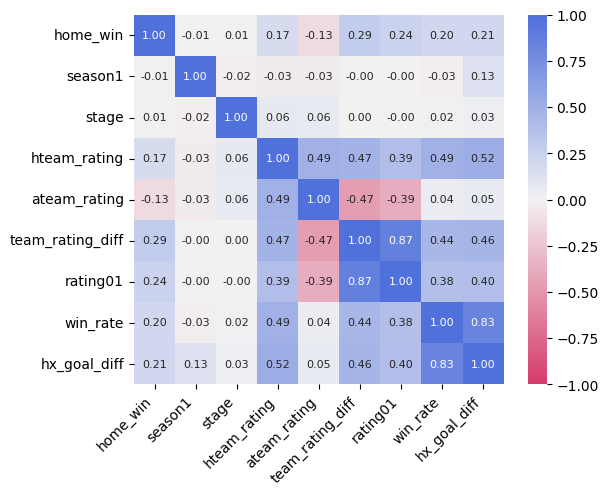

In [42]:
# fmt: off
# Correlation matrix
corr = num_cols.corr(method="spearman")
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(0, 260, n=200),
    square=True, annot=True, fmt=".2f", annot_kws={"fontsize": 8})

# Reduce the font size of the x and y tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set colourbar font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

# Rotate x axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right");

# Most promising in decreasing order: team_rating_diff, rating01, win_rate

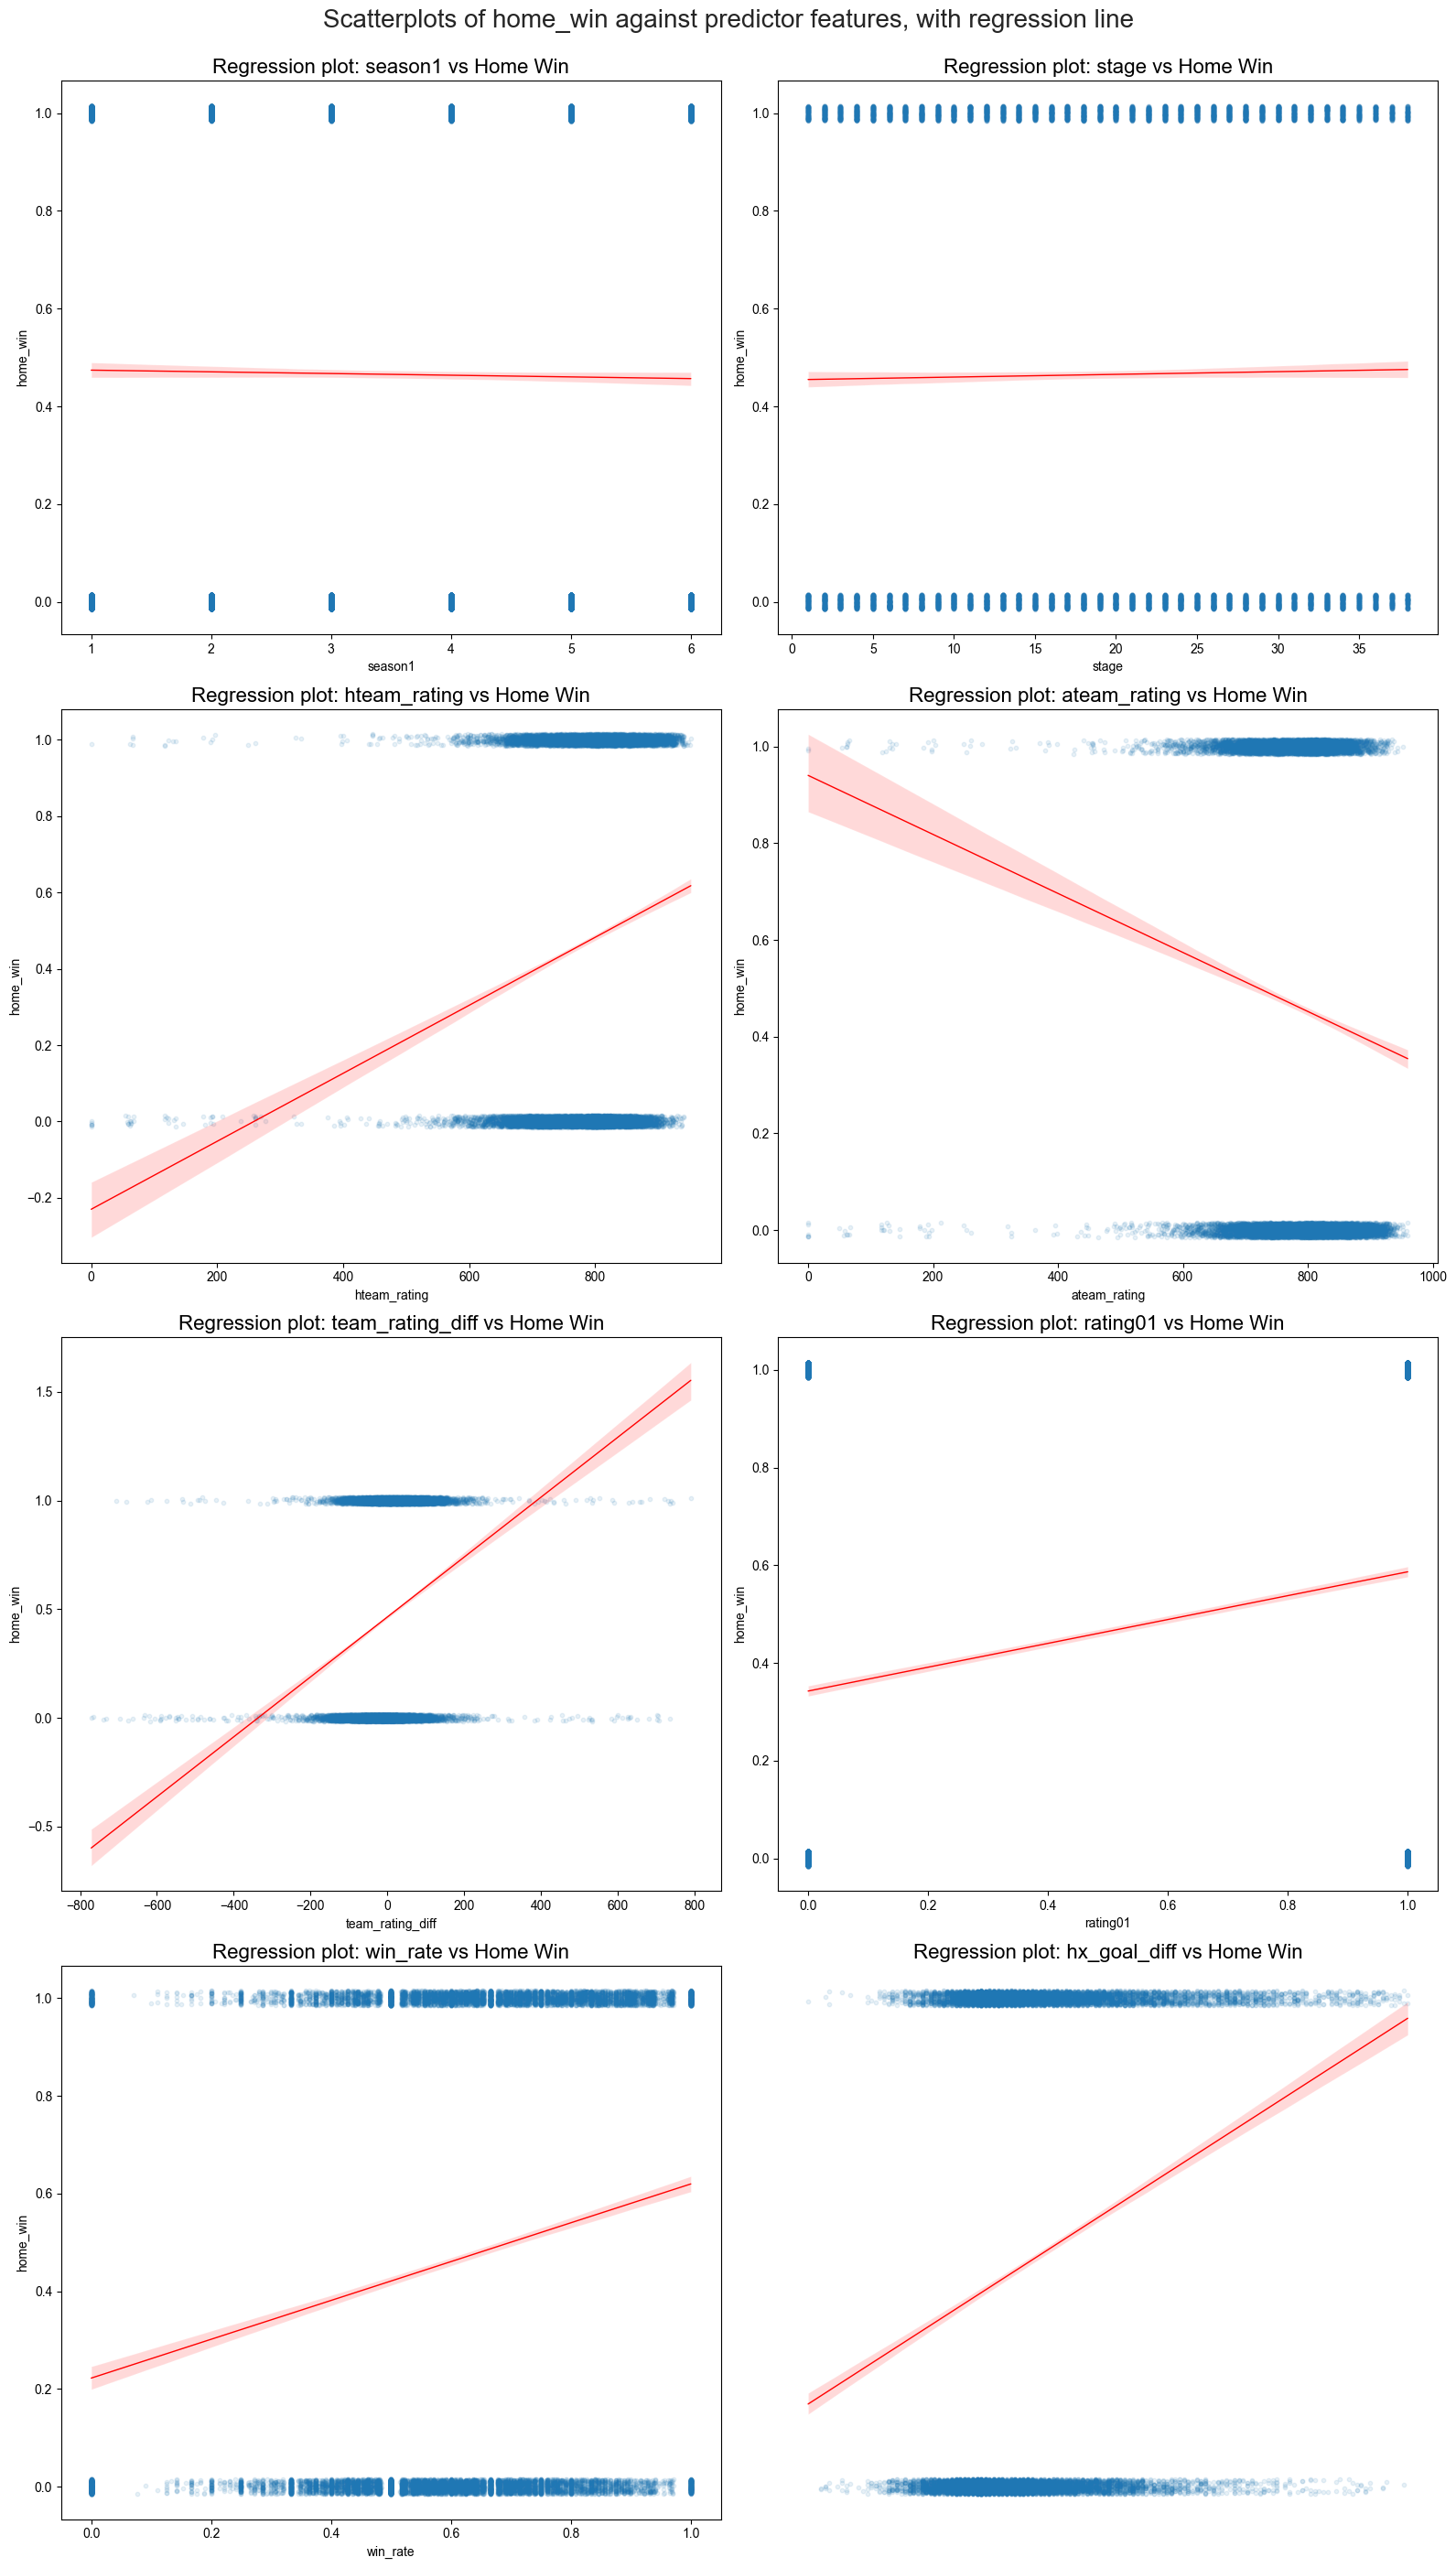

In [43]:
# Scatterplots with regression line
fig, axes = plt.subplots(4, 2, figsize=(16, 28))
sns.set_style("whitegrid")

# Remove outcome from list of numeric variables
num_cols_nowin = num_cols.drop("home_win", axis=1)

for index, var in enumerate(num_cols_nowin):
    row, col = divmod(index, 2)  # Calculate the row and column for the current subplot
    ax = axes[row, col]  # Get the current subplot

    sns.regplot(
        data=train,
        x=var,
        y="home_win",
        scatter_kws={"s": 10, "alpha": 0.1},
        line_kws={"color": "red", "linewidth": 1},
        y_jitter=0.015,
        ax=ax,  # Specify the current subplot
    )

    ax.set_title(f"Regression plot: {var} vs Home Win", fontsize=16)

# Adjust the layout and labels
axes[3, 1].set_axis_off()
fig.suptitle(
    "Scatterplots of home_win against predictor features, with regression line",
    y=1.00,
    fontsize=20,
)
fig.tight_layout(pad=1.0)
plt.show()

In [44]:
# Check for duplicate rows
duplicate_rows = train.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())
train_no_duplicates = train.drop_duplicates()

Number of duplicate rows: 0


<span style= "color:blue">

#### **_Q6.4 Stepwise regression_** </span>

In [45]:
# fmt: off
# Stepwise regression (backward)
# Create list of predictors
predictors = ['stage', 'team_rating_diff', 'rating01', 'win_rate', 
              'season1', 'country_England', 'country_France', 'country_Germany', 'country_Italy', 'country_Netherlands',
              'country_Poland', 'country_Portugal', 'country_Scotland', 'country_Spain', 'country_Switzerland']

# Define predictors and outcome vars
X_train = train[predictors]
y_train = train["home_win"]

# Instantiate Logistic Regression model
logistic_regression = LogisticRegression()

# Instantiate SequentialFeatureSelector with Logistic Regression
sfs = SequentialFeatureSelector(logistic_regression, k_features="parsimonious", verbose=2, scoring='accuracy', forward=False)

# Fit the SequentialFeatureSelector to the data
sfs.fit(X_train, y_train)

# Print the selected features
print("Best accuracy score: %.2f" % sfs.k_score_)
print("Best subset (indices):", sfs.k_feature_idx_)
print("Best subset (corresponding names):", sfs.k_feature_names_)


[2024-07-08 19:31:01] Features: 14/1 -- score: 0.6274471544715448
[2024-07-08 19:31:19] Features: 13/1 -- score: 0.6286829268292683
[2024-07-08 19:31:34] Features: 12/1 -- score: 0.6290081300813009
[2024-07-08 19:31:49] Features: 11/1 -- score: 0.6289430894308943
[2024-07-08 19:32:01] Features: 10/1 -- score: 0.6290081300813009
[2024-07-08 19:32:14] Features: 9/1 -- score: 0.6290081300813009
[2024-07-08 19:32:23] Features: 8/1 -- score: 0.6288130081300813
[2024-07-08 19:32:30] Features: 7/1 -- score: 0.6289430894308943
[2024-07-08 19:32:36] Features: 6/1 -- score: 0.6290081300813009
[2024-07-08 19:32:40] Features: 5/1 -- score: 0.6282926829268293
[2024-07-08 19:32:43] Features: 4/1 -- score: 0.6277723577235772
[2024-07-08 19:32:45] Features: 3/1 -- score: 0.6273170731707317
[2024-07-08 19:32:46] Features: 2/1 -- score: 0.6251707317073171

Best accuracy score: 0.63
Best subset (indices): (1,)
Best subset (corresponding names): ('team_rating_diff',)



[2024-07-08 19:32:47] Features: 1/1 -- score: 0.625430894308943

<span style= "color:blue">

#### **_Q6.5 Fit model to predict home wins_** </span>

<span style="color:blue">
    
##### **_Q6.5.1 Preprocessing: Assessing for and handling missing values_** </span>

In [46]:
# Prep for modelling
# Check for missing values in each column
win_rate_missing = train.isnull().sum()

# Print columns with missing values
print("Columns with missing values:")
print(win_rate_missing[win_rate_missing > 0])

Columns with missing values:
Series([], dtype: int64)


<span style="color:blue">
    
##### **_Q6.5.2 Fit model_** </span>

In [47]:
# Fit model to predict home win
# List of individual predictors including countries
countries = [
    "country_England",
    "country_France",
    "country_Germany",
    "country_Italy",
    "country_Netherlands",
    "country_Poland",
    "country_Portugal",
    "country_Scotland",
    "country_Spain",
    "country_Switzerland",
]

predictors = ["team_rating_diff", "win_rate", "rating01", "hx_goal_diff"] + countries

# Fit and evaluate models for individual predictors
for predictor in predictors:
    X_train_single = train[predictor].values.reshape(-1, 1)
    X_test_single = test[predictor].values.reshape(-1, 1)

    y_train_single = train["home_win"]
    y_test_single = test["home_win"]

    # Fit the model with data
    logreg_homewin_single = LogisticRegression(class_weight="balanced", random_state=0)
    logreg_homewin_single.fit(X_train_single, y_train_single)

    # Test on test data
    y_pred_single = logreg_homewin_single.predict(X_test_single)

    # Score (mean accuracy)
    accuracy_single = metrics.accuracy_score(y_test_single, y_pred_single)
    print(f"Accuracy for {predictor}: {accuracy_single}")

# Fit the full model with all predictors
X_train_full = train[predictors]
X_test_full = test[predictors]

y_train_full = train["home_win"]
y_test_full = test["home_win"]

logreg_homewin_full = LogisticRegression(class_weight="balanced", random_state=0)
logreg_homewin_full.fit(X_train_full, y_train_full)

# Test on test data
y_pred_full = logreg_homewin_full.predict(X_test_full)

# Score (mean accuracy)
accuracy_full = metrics.accuracy_score(y_test_full, y_pred_full)
print(f"\nAccuracy for the full model: {accuracy_full}")

# Confusion matrix, which includes accuracy
cnf_matrix_full = metrics.confusion_matrix(y_test_full, y_pred_full)
print("\nConfusion Matrix for the full model:")
print(cnf_matrix_full)

# Print metrics for the full model
target_names = ["Home loss", "Home win"]
print("\nClassification Report for the full model:")
print(classification_report(y_test_full, y_pred_full, target_names=target_names))

Accuracy for team_rating_diff: 0.6284380730121687
Accuracy for win_rate: 0.6064344057342891
Accuracy for rating01: 0.6274379063177197
Accuracy for hx_goal_diff: 0.6191031838639773
Accuracy for country_England: 0.461576929488248
Accuracy for country_France: 0.456242707117853
Accuracy for country_Germany: 0.4529088181363561
Accuracy for country_Italy: 0.5385897649608268
Accuracy for country_Netherlands: 0.5457576262710452
Accuracy for country_Poland: 0.5505917652942157
Accuracy for country_Portugal: 0.45457576262710453
Accuracy for country_Scotland: 0.45174195699283215
Accuracy for country_Spain: 0.5472578763127188
Accuracy for country_Switzerland: 0.45224204034005666

Accuracy for the full model: 0.6351058509751625

Confusion Matrix for the full model:
[[2176 1158]
 [1031 1634]]

Classification Report for the full model:
              precision    recall  f1-score   support

   Home loss       0.68      0.65      0.67      3334
    Home win       0.59      0.61      0.60      2665

    

In [48]:
# Fit the full model with best two predictors
# scaled data version to inspect

# Fit the full model with best two predictors
predictors = ["team_rating_diff", "hx_goal_diff"]

X_train_full = train[predictors]
X_test_full = test[predictors]

# Scale features
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_full_scaled = scaler.transform(X_test_full)

y_train_full = train["home_win"]
y_test_full = test["home_win"]

logreg_homewin_full = LogisticRegression(class_weight="balanced", random_state=0)
logreg_homewin_full.fit(X_train_full_scaled, y_train_full)

# Test on test data
y_pred_full = logreg_homewin_full.predict(X_test_full_scaled)

# Score (mean accuracy)
accuracy_full = metrics.accuracy_score(y_test_full, y_pred_full)
print(f"\nAccuracy for the full model: {accuracy_full}")

# Confusion matrix, which includes accuracy
cnf_matrix_full = metrics.confusion_matrix(y_test_full, y_pred_full)
print("\nConfusion Matrix for the full model:")
print(cnf_matrix_full)

# Print metrics and coefficients for the full model
target_names = ["Home loss", "Home win"]
print("\nClassification Report for the full model:")
print(classification_report(y_test_full, y_pred_full, target_names=target_names))

coefficients = logreg_homewin_full.coef_[0]
intercept = logreg_homewin_full.intercept_[0]
print(f"Intercept: {intercept}")
print(f"Coefficients: {coefficients}")


Accuracy for the full model: 0.6357726287714619

Confusion Matrix for the full model:
[[2281 1053]
 [1132 1533]]

Classification Report for the full model:
              precision    recall  f1-score   support

   Home loss       0.67      0.68      0.68      3334
    Home win       0.59      0.58      0.58      2665

    accuracy                           0.64      5999
   macro avg       0.63      0.63      0.63      5999
weighted avg       0.63      0.64      0.64      5999

Intercept: -0.004626795608176416
Coefficients: [0.47377848 0.29940043]


In [49]:
# Apply auto feature engineering for comparison
y = train["home_win"]
X = train[predictors]

X_test = test[predictors]

model = AutoFeatClassifier()
df = model.fit_transform(X, y)

y_pred = model.predict(X_test)

print("Final Accuracy: %.4f" % model.score(df, y))
df.columns

# Final Accuracy: 0.6229
# Index(['team_rating_diff', 'win_rate', 'rating01', 'country_England',
#        'country_France', 'country_Germany', 'country_Italy',
#        'country_Netherlands', 'country_Poland', 'country_Portugal',
#        'country_Scotland', 'country_Spain', 'country_Switzerland',
#        'rating01*win_rate**2'],
#       dtype='object')

Final Accuracy: 0.5646


Index(['team_rating_diff', 'hx_goal_diff', 'team_rating_diff**3',
       'Abs(team_rating_diff)', 'hx_goal_diff*team_rating_diff'],
      dtype='object')

<span style= "color:blue">

*****_Q6.5.3 Summary of findings_***** </span>
* The full model accuracy level is 62.9%, which is nearly the same level of accuracy as the model with only team overall rating difference (62.8%), as well as the model with the dichotomous team overall rating difference (62.7%).
    * The dichotomous overall team rating measures whether the overall team rating for the home team (which is the average of the most up-to-date rating of all 11 team players) is greater than that of the away team.
* We will select the model with two predictors: the historical** difference between home team and away team overall ratings, and the historical** difference in home and away team goals. The combination of these two predictors achieved an accuracy score of 64%
* The model parameters are not reliable because they do not meet the linearity assumption, but for general interest, it predicts that if we take the data from the last 35 matches before a particular match:
    - each unit increase in the difference in overall team rating between the home and away teams is associated with a 0.54% increase in the odds of the home team winning
    - each unit increase in the difference between the number of home and away team goals is associated with a 1.5% increase in the odds of the home team winning 

** historical - interpreted as state of ratings or goals) in the last 35 matches before a particular match

<span style= "color:blue">

#### **_Q6.6 Check assumptions_**  </span>

<span style="color:blue">

#### **_(1) Appropriate outcome type_** 

##### **_(1) Outcome assumption met_** </span>

   * Wine outcome was dichotomised for this analysis._

<span style="color:blue">

#### **_(2) Linearity: Relationship between predictor and log-odds of outcome variables is linear_** 

##### **_Hypothesis test #3: Box-Tidwell test_**: </span>

**H<sub>o</sub>:** Predictor variables have a linear relationship with log-odds of outcome

**H<sub>a</sub>:** Predictor variables do NOT have a linear relationship with log-odds of outcome


In [50]:
# # Linearity assumption: Box Tidwell
# identify positive continuous variables (Box Tidwell only works for positive values)
# Function to round each value in the DataFrame to the desired decimal places

# list of continuous columns
continuous_col = match_final[["team_rating_diff", "win_rate"]]

# Round  elements in the df
df = continuous_col.applymap(round_to_decimal_places)

# Remove rows with at least one zero value
rows_with_zero = df.loc[(df == 0.0).any(axis=1)]  # 0 rows

# Identify rows without zero
rows_without_zero = df.loc[
    ~df.index.isin(rows_with_zero.index)
]  # in case model changes

# Add logit transform interaction terms for continuous variables
# Define predictor and outcome
X_lt = rows_without_zero
add_log_transformations(X_lt)
y_lt = match_final["home_win"]

# Merge into one df
match_lt = X_lt.merge(y_lt, left_index=True, right_index=True)
match_lt.columns

Index(['team_rating_diff', 'win_rate', 'team_rating_diff_log', 'win_rate_log',
       'home_win'],
      dtype='object')

In [51]:
# fmt: off

# Build model and fit the data (using statsmodel's Logit)
formula = "home_win ~ team_rating_diff + win_rate + team_rating_diff_log + win_rate_log"
data = pd.concat([y_lt, X_lt], axis=1)
logit_results = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               home_win   No. Observations:                10500
Model:                            GLM   Df Residuals:                    10495
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6880.2
Date:                Mon, 08 Jul 2024   Deviance:                       13760.
Time:                        19:48:48   Pearson chi2:                 1.05e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04656
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.4465 

<span style="color:blue">

##### **_(2) Linearity assumption not met_**</span>

* Significant p-values for the logit transformed interaction terms for (1) team_rating_diff:team_rating_diff_log** and (2) win_rate:win_rate_log, suggesting non-linearity
* **Box-Tidwell test result:** Reject H<sub>o</sub>; linearity assumption violated
  - The next step would be to identify potential transformations (eg. add interaction terms or splines) that might help the model conform to linearity assumption 

** the colon : represents an interaction term
  
<span style="color:blue">

#### **_(3) No multicollinearity_**</span>


In [52]:
# fmt: off
# Assumption #4: No multicollinearity

# Define predictors
predictors_home_win = match_final[["team_rating_diff", "win_rate"]]

X = add_constant(predictors_home_win)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns  # create df with 1 column of model features

# calculating VIF for each feature
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(X.shape[1])
]  # apply library function

print(vif_data)

            feature       VIF
0             const  9.974974
1  team_rating_diff  1.165860
2          win_rate  1.165860


<span style="color:blue">

##### **_(3) Multicollinearity assumption met_**</span>

* VIF < 5 therefore multicollinearity levels are low
* Consistent with correlation matrix findings 
    - Spearman's correlation coefficient between the two variables was .44)

<span style="color:blue">

#### **_(4) Sufficiently large sample size_**</span>

* Number of observations (21374) > 500.**

**_[Bujang, M et al. Sample Size Guidelines for Logistic Regression from Observational Studies with Large Population: Emphasis on the Accuracy Between Statistics and Parameters Based on Real Life Clinical Data. Malays J Med Sci, 2018.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6422534/)_

<a id='summary'></a>

<span style="color:blue">
    
##### **_(4) Sample size assumption met_**</span>


<span style="color:blue">

##### **_Q6.6 Summary of assumption check_**</span>

Assumption|Met assumption |Method |
|:----|:----|:----|
|1) Appropriate outcome | Yes | Created dependent variable |
|2) Linearity  | No |Box-Tidwell test |
|3) No multicollinearity| Yes |VIF<5; correlation matrix |
|4) Sufficiently large sample size |Yes | >500 |||

<span style="color:blue">

#### **_Q6 Overall findings (Can we predict which team will win a match?)_**</span>

- Answer: Yes! We have a good idea of how this can be predicted though a preliminary model.
- The preliminary model for predicting the likelihood of a home team win is based on data from the last 35 matches before a particular match, using:
    - the difference between home team and away team overall ratings, and
    - the difference between the number of home team and away team goals
- Because the relationship did not meet the assumption of linearity, it still needs to be fine tuned.  

<span style="color:blue">
    
### **_Q5. Can we predict how many goals each team will score in each match?_**

#### **_Q5.1 Bivariate analysis_** </span>


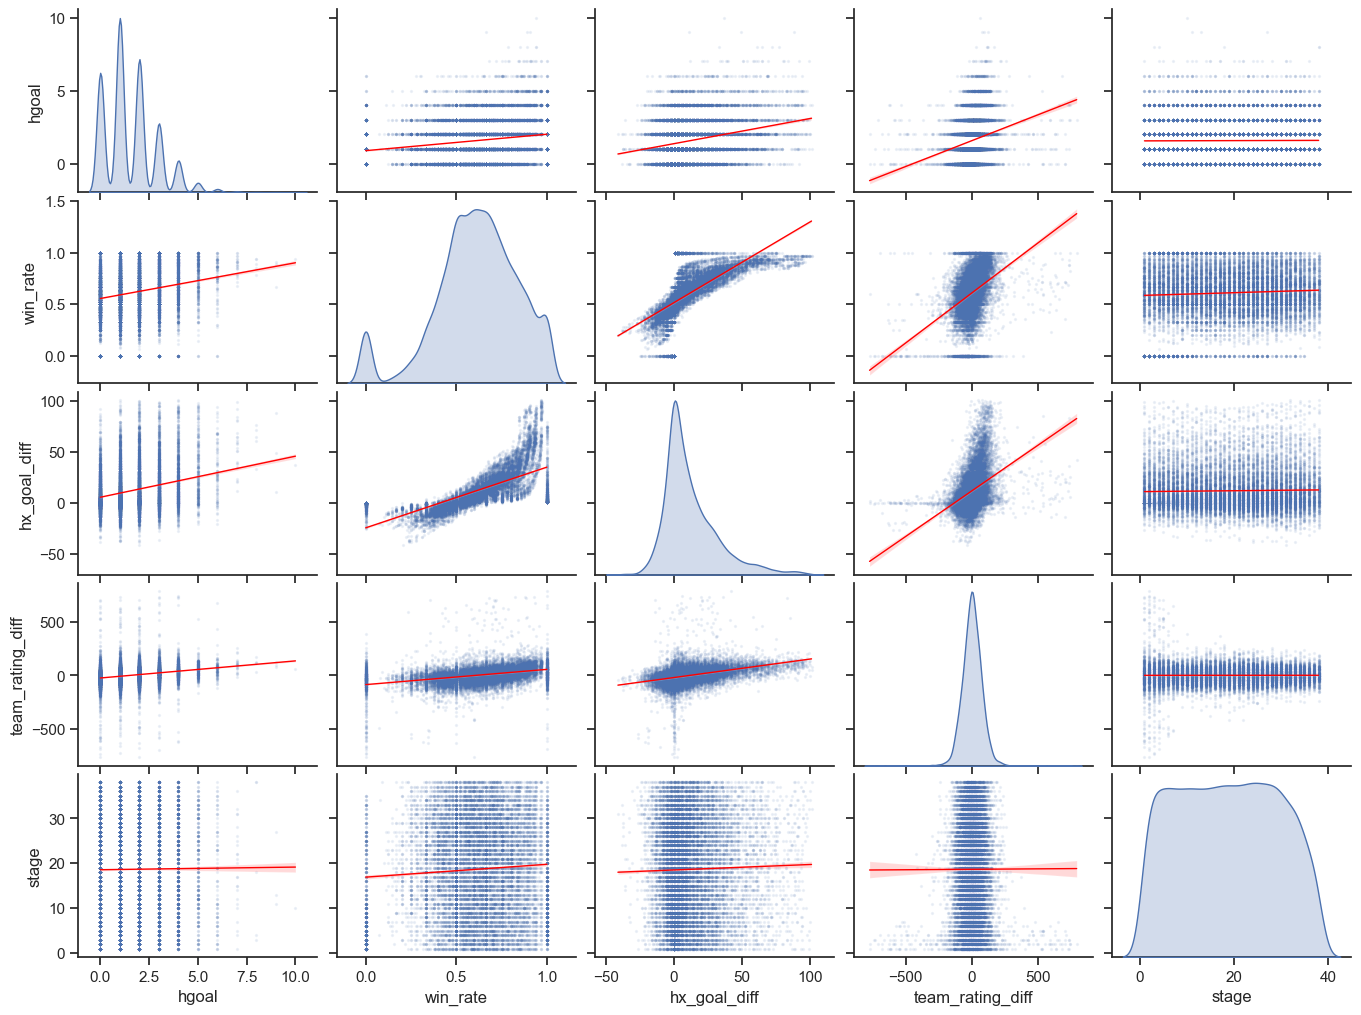

In [53]:
# Modify your function to accept a DataFrame and column names
# Inspect potential predictors identified from literature search
# Note: "Country" stands in for league
plot_pairplot(
    train, "hgoal", ["win_rate", "hx_goal_diff", "team_rating_diff", "stage", "country"]
)

In [54]:
# Investigate potential predictors from team attributes table

query = """
SELECT m.id, m.home_team_goal hgoal, ta.buildUpPlayPassing bu_passing, ta.chanceCreationPassing cc_passing,
ta.chanceCreationShooting cc_shooting
FROM Match m
JOIN Team_Attributes ta on ta.team_api_id = m.home_team_api_id
"""
team_att_hgoal = pd.read_sql_query(query, conn)
team_att_hgoal.shape

(142093, 5)

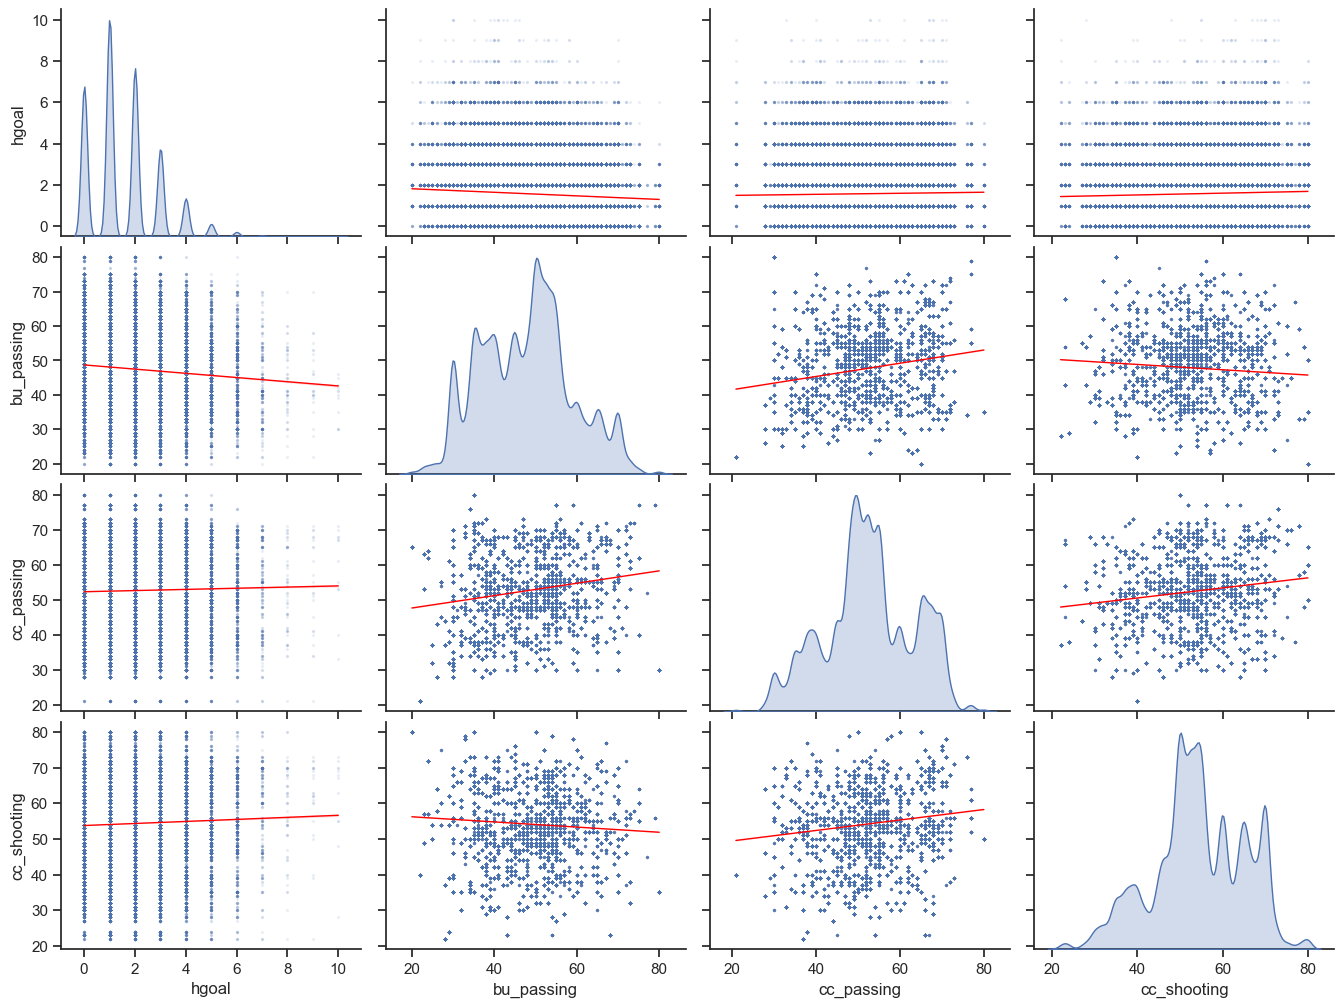

In [55]:
# fmt: off
# Search for low hanging fruit potential predictors (ie that do not require additional feature engineering)
# Pairplot with selected team attributes, identified from team_attributes table via literature review
plot_pairplot(team_att_hgoal, "hgoal", ['bu_passing', 'cc_passing', 'cc_shooting'])

<span style="color:blue">
    
#### **_Insights on modelling from pairplots_**</span>

- None of the potential features appear to be good predictors, including those derived from feature engineering and selected team attributes that approximated predictors mentioned in literature review.
- The most promising potential features appear to be: win_rate, hx_goal_diff, and less so, team_rating_diff

<span style="color:blue">
    
#### **_Q5.2 Fit different combinations of potential predictors to assess explanatory power_** </span> 

In [56]:
# Home_win ~ different predictor sets

# List of predictor sets
predictor_sets = [
    ["win_rate"],
    ["hx_goal_diff"],
    ["team_rating_diff"],
    ["team_rating_diff", "win_rate", "hx_goal_diff"],
    ["team_rating_diff", "win_rate", "hx_goal_diff", "country"],
]

# Fit linear models for each predictor set
for predictors in predictor_sets:
    fit_linear_regression(train, predictors, "hgoal")



**Linear Regression: hgoal ~ ['win_rate']**  ----------------------------------------

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  hgoal   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     623.0
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          7.89e-135
Time:                        19:54:49   Log-Likelihood:                -25583.
No. Observations:               15375   AIC:                         5.117e+04
Df Residuals:                   15373   BIC:                         5.119e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8814      0.029     29.945      0.000       0.824       0.939
win_rate       1.1276      0.045     24.960      0.000       1.039       1.216
==============================================================================
Omnibus:                     1636.557   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2291.399
Skew:                           0.842   Prob(JB):                         0.00
Kurtosis:                       3.862   Cond. No.                         6.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""



**RMSE of residuals: 1.2777389476989187** ----------------------------------------





**Linear Regression: hgoal ~ ['hx_goal_diff']**  ----------------------------------------

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  hgoal   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     1144.
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          5.40e-242
Time:                        19:54:49   Log-Likelihood:                -25337.
No. Observations:               15375   AIC:                         5.068e+04
Df Residuals:                   15373   BIC:                         5.069e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.3598      0.012    114.393      0.000       1.336       1.383
hx_goal_diff     0.0173      0.001     33.827      0.000       0.016       0.018
==============================================================================
Omnibus:                     1468.469   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1976.746
Skew:                           0.795   Prob(JB):                         0.00
Kurtosis:                       3.747   Cond. No.                         27.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""



**RMSE of residuals: 1.2574168463473796** ----------------------------------------





**Linear Regression: hgoal ~ ['team_rating_diff']**  ----------------------------------------

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  hgoal   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     931.0
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          1.42e-198
Time:                        19:54:49   Log-Likelihood:                -25437.
No. Observations:               15375   AIC:                         5.088e+04
Df Residuals:                   15373   BIC:                         5.089e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.5677      0.010    153.594      0.000       1.548       1.588
team_rating_diff     0.0036      0.000     30.512      0.000       0.003       0.004
==============================================================================
Omnibus:                     1633.475   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2322.942
Skew:                           0.829   Prob(JB):                         0.00
Kurtosis:                       3.937   Cond. No.                         87.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""



**RMSE of residuals: 1.265613195271892** ----------------------------------------





**Linear Regression: hgoal ~ ['team_rating_diff', 'win_rate', 'hx_goal_diff']**  ----------------------------------------

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  hgoal   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     512.3
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          2.55e-317
Time:                        19:54:50   Log-Likelihood:                -25156.
No. Observations:               15375   AIC:                         5.032e+04
Df Residuals:                   15371   BIC:                         5.035e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.4012      0.034     41.307      0.000       1.335       1.468
team_rating_diff     0.0024      0.000     18.851      0.000       0.002       0.003
win_rate             0.0148      0.061      0.244      0.807      -0.104       0.134
hx_goal_diff         0.0130      0.001     18.467      0.000       0.012       0.014
==============================================================================
Omnibus:                     1429.484   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1921.558
Skew:                           0.777   Prob(JB):                         0.00
Kurtosis:                       3.763   Cond. No.                         604.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""



**RMSE of residuals: 1.2428083669004566** ----------------------------------------





**Linear Regression: hgoal ~ ['team_rating_diff', 'win_rate', 'hx_goal_diff', 'country']**  ----------------------------------------

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  hgoal   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     128.6
Date:                Mon, 08 Jul 2024   Prob (F-statistic):               0.00
Time:                        19:54:50   Log-Likelihood:                -25095.
No. Observations:               15375   AIC:                         5.022e+04
Df Residuals:                   15361   BIC:                         5.032e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.4219      0.055     25.644      0.000       1.313       1.531
country[T.England]        -0.0616      0.052     -1.189      0.234      -0.163       0.040
country[T.France]         -0.2218      0.052     -4.267      0.000      -0.324      -0.120
country[T.Germany]         0.0350      0.053      0.654      0.513      -0.070       0.140
country[T.Italy]          -0.1261      0.052     -2.411      0.016      -0.229      -0.024
country[T.Netherlands]     0.1852      0.055      3.358      0.001       0.077       0.293
country[T.Poland]          0.0986      0.114      0.866      0.387      -0.125       0.322
country[T.Portugal]       -0.1281      0.062     -2.052      0.040      -0.250      -0.006
country[T.Scotland]       -0.1085      0.058     -1.877      0.061      -0.222       0.005
country[T.Spain]        6.554e-05      0.053      0.001      0.999      -0.103       0.103
country[T.Switzerland]     0.0149      0.061      0.242      0.809      -0.106       0.135
team_rating_diff           0.0024      0.000     19.022      0.000       0.002       0.003
win_rate                   0.0756      0.061      1.229      0.219      -0.045       0.196
hx_goal_diff               0.0122      0.001     17.265      0.000       0.011       0.014
==============================================================================
Omnibus:                     1355.170   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1793.092
Skew:                           0.755   Prob(JB):                         0.00
Kurtosis:                       3.722   Cond. No.                     1.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""



**RMSE of residuals: 1.2382332118247081** ----------------------------------------



<span style="color:blue">
    
#### **_Insights from modelling_**</span>
- Very poor explanatory power in general, so available features are weak options. Finding a good model would require additional feature engineering
- "Best" model
      - team_rating_diff + win_rate + 'hx_goal_diff + country
      - Adjusted R<sup>2</sup> of = 9.7%, RMSE = 1.24

<span style="color:blue">
    
#### **_Q5.2 Check selected assumptions_**</span>


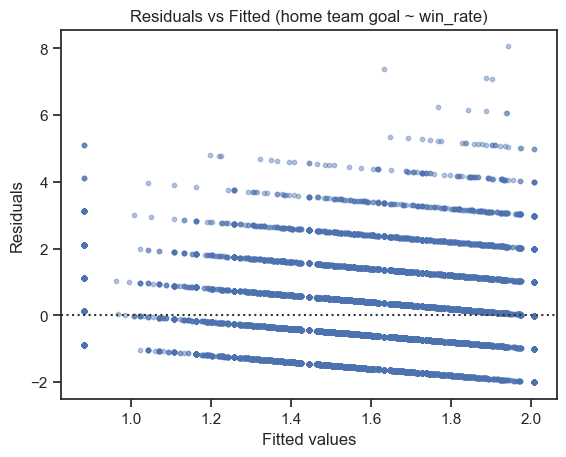

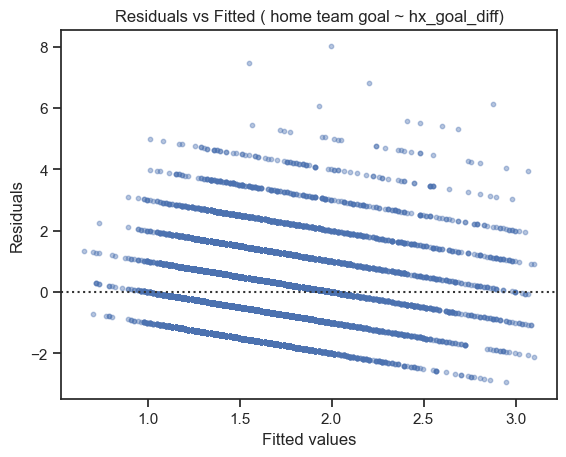

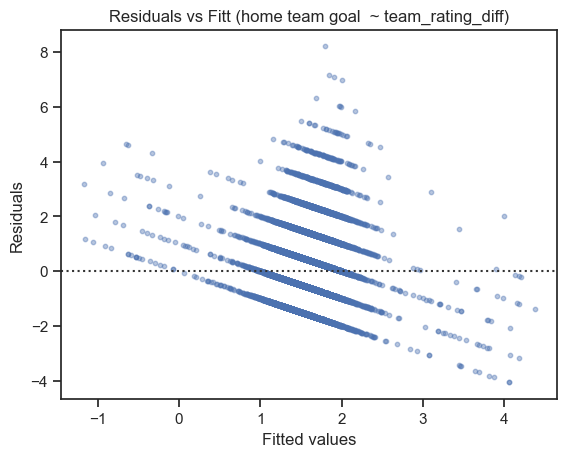

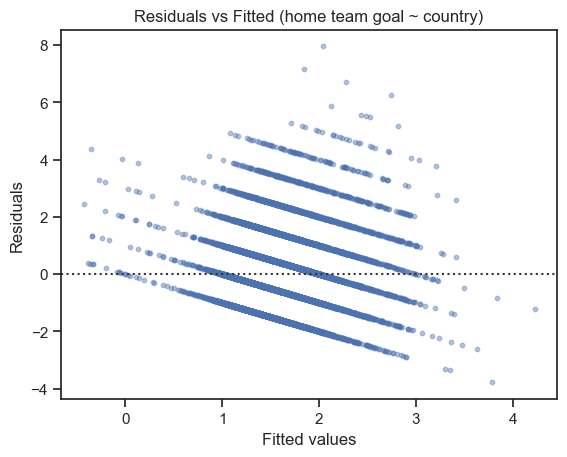

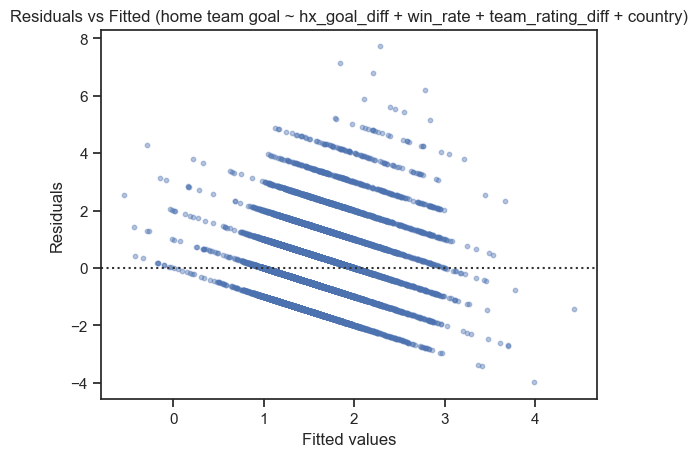

In [57]:
# fmt: off
# Bivariate residuals vs fitted values for 6 selected variables
# List regression_specs regression specifications
regression_specs = [
    ("win_rate", "hgoal","Residuals vs Fitted (home team goal ~ win_rate)"),
    ("hx_goal_diff", "hgoal", "Residuals vs Fitted ( home team goal ~ hx_goal_diff)"), 
    ("team_rating_diff", "hgoal", "Residuals vs Fitt (home team goal  ~ team_rating_diff)"),
    ("hx_goal_diff + win_rate + team_rating_diff", "hgoal", "Residuals vs Fitted (home team goal ~ country)"),
    ("hx_goal_diff + win_rate + team_rating_diff + country", "hgoal", "Residuals vs Fitted (home team goal ~ hx_goal_diff + win_rate + team_rating_diff + country)"),   
]

# Create residual plots for each specification
for spec in regression_specs:
    plot_residuals(train, spec[0], spec[1], spec[2])

<span style="color:blue">
    
#### **_Q5.3 Summary of findings on assumption checking_**</span>

Selected model (which does not explain, let alone predict, goals for each team) did **not** meet assumptions of:
- **Linearity**: Residuals are not randomly distributed around the residual = 0 line, making it clear that the assumption of a linear relationship is violated.
- **Homoskedasticity**: Residuals from left to right do not have uniform distance from the residual = 0 line, showing that the variances of the error terms are not equal.
- **Outliers**: There are residuals that are 4 to 6 standard deviations from the residual = 0 line, suggesting a plethora of outliers.


<span style="color:blue">
    
#### **_Q5 Findings: prediction of number of goals for home team_**</span>

- The best model using previously engineered features explained only 10% of the variance in the data for the number of goals for each team. As might be expected, this poor fit was also reflected when we checked the residuals agains the fitted values.  


<div class="alert alert-warning">
<font color= black>
    
## **_Part IV: Summary of Findings_** </font></div>

* Among the six guiding questions, we found definitive answers for the first four.
* Prediction questions:
  - For Q5 _Can we predict how many goals each team will score in each match?_, we have not yet identified good predictors, but we shared directions for further analysis, informed by literature search.  
  - For Q6. _Can we predict which team will win the match?_, we identified a promising preliminary model, pending meeting linearity assumption 


<span style="color:blue">
    
### **_How could this analysis be improved?_**</span>

Q6 _Can we predict which team will win the match?_
- The analysis could have explored the use of transformations and splines to meet the linearity
  assumption and to derive more accurate parameter estimates.

Q5 _Can we predict how many goals each team will score in each match?_
- The analysis could have included:
  - additional feature engineering, including features cited in previous studies such as
      (1) historical number of shots per match on goal of strikers, attacking midfielders and
          wingers, and
      (2) historical efficiency of shots on goal (number of goals/number of shots on goal)
          per match. Because the Kaggle data for such data do not seem reliable, the analysis could
          have included data from other sources. 
  - feature(s) derived from betting company odds, although for a betting company it probably would
    not be a viable business strategy because the company would depend on other betting companies,
    publishing their data which would make it always late to the game and/or vulnerable to reliance
    on potentially inaccurate odds data.

<div class="alert alert-warning">
<font color= black>
    
## **_Part V: Key references_** </font></div>

1. [Holmes, B. et al. Forecasting football match results using a player rating based model.](https://www.sciencedirect.com/science/article/pii/S016920702300033X) Internaional Journal of Forecasting. Available online 8 April 2023.

2. [Lepschy, H et al. How to be successful in football: a systematic review.](https://www.researchgate.net/publication/326202941_How_to_be_Successful_in_Football_A_Systematic_Review) The Open Sports Sciences Journal, Volume 11. 2018.

3. [Sarmentoa, H et al. Match analysis in football: a systematic review.](https://www.researchgate.net/publication/262023174_Match_analysis_in_football_a_systematic_review) Journal of Sports Sciences. 2014.